In [1]:
%matplotlib inline


# Feature transformations with ensembles of trees


Transform your features into a higher dimensional, sparse space. Then
train a linear model on these features.

First fit an ensemble of trees (totally random trees, a random
forest, or gradient boosted trees) on the training set. Then each leaf
of each tree in the ensemble is assigned a fixed arbitrary feature
index in a new feature space. These leaf indices are then encoded in a
one-hot fashion.

Each sample goes through the decisions of each tree of the ensemble
and ends up in one leaf per tree. The sample is encoded by setting
feature values for these leaves to 1 and the other feature values to 0.

The resulting transformer has then learned a supervised, sparse,
high-dimensional categorical embedding of the data.



In [2]:
# Author: Tim Head <betatim@gmail.com>
#
# License: BSD 3 clause

import numpy as np
np.random.seed(10)

import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import make_pipeline

n_estimator = 10
X, y = make_classification(n_samples=80000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
# It is important to train the ensemble of trees on a different subset
# of the training data than the linear regression model to avoid
# overfitting, in particular if the total number of leaves is
# similar to the number of training samples
X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train,
                                                            y_train,
                                                            test_size=0.5)
print(X)
print(y)

[[-1.31195976  0.05922712  0.04675065 ...,  1.11429335  1.16595316
   0.95277777]
 [ 0.73048208 -0.39879798  1.14877387 ...,  1.72930232  0.46581252
  -0.22762372]
 [ 1.12451537  0.36959044  0.73640005 ..., -0.57955917 -0.10214023
  -2.15954465]
 ..., 
 [-0.44011954 -0.3648611   0.13247199 ...,  0.0350504   0.46964275
   0.80800214]
 [-1.3036859   0.36104309  1.220873   ..., -1.500089    0.7435263
   0.26565638]
 [ 1.32330734  0.08307262 -0.0704902  ...,  1.13262653  1.1000763
  -1.73888715]]
[0 0 1 ..., 1 1 1]


In [3]:
# Unsupervised transformation based on totally random trees
rt = RandomTreesEmbedding(max_depth=3, n_estimators=n_estimator,
	random_state=0)

rt_lm = LogisticRegression()
pipeline = make_pipeline(rt, rt_lm)
pipeline.fit(X_train, y_train)
y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)
print('LR AUC: {:.4f}'.format(auc(fpr_rt_lm, tpr_rt_lm)))

LR AUC: 0.9669


In [4]:
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
rf_enc = OneHotEncoder()
rf_lm = LogisticRegression()
rf.fit(X_train, y_train)
rf_enc.fit(rf.apply(X_train))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)
y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)
print('RF+LR AUC: {:.4f}'.format(auc(fpr_rf_lm, tpr_rf_lm)))

RF+LR AUC: 0.9724


In [5]:
grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd_enc = OneHotEncoder()
grd_lm = LogisticRegression()
grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0])
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)
print('GBDT+LR AUC: {:.4f}'.format(auc(fpr_grd_lm, tpr_grd_lm)))

GBDT+LR AUC: 0.9847


In [6]:
leaf_predi = grd.apply(X_train_lr)
leaf_predi.shape

(20000, 10, 1)

In [7]:
# The gradient boosted model by itself
y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)
print('GBDT AUC: {:.4f}'.format(auc(fpr_grd, tpr_grd)))

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print('RF AUC: {:.4f}'.format(auc(fpr_rf, tpr_rf)))

GBDT AUC: 0.9822
RF AUC: 0.9657


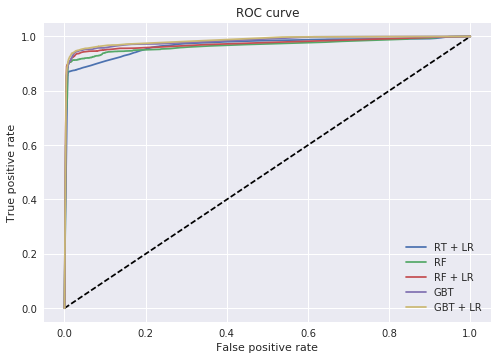

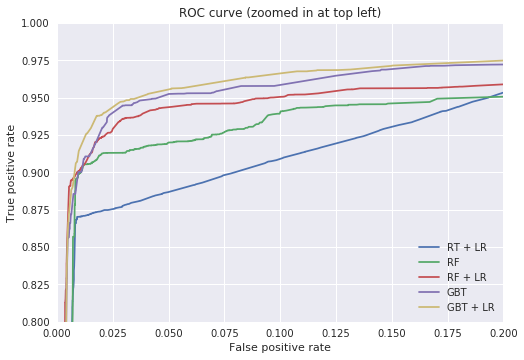

In [10]:
# import seaborn as sns
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

###  交叉熵
* 交叉熵代价函数的产生以及与二次代价的优劣：http://blog.csdn.net/yimingsilence/article/details/52740638
* 现有关于样本集的2个概率分布p和q，其中p为真实分布，q非真实分布。按照真实分布p来衡量识别一个样本的所需要的编码长度的期望(即平均编码长度) $H(p)$, 使用错误分布q来表示来自真实分布p的平均编码长度为 $H(p,q)$, H(p,q) 称之为“交叉熵”
$$H(p)=\sum_{i}^{}p(i)log\frac{1}{p(i)}$$
$$H(p,q)=\sum_{i}^{}p(i)log\frac{1}{q(i)}$$
$H(p,q) \ge H(p)$ 恒成立
*  当且仅当 q 分布与真实分布p 相同， 等号成立.

* 这里将由q得到的平均编码长度比由p得到的平均编码长度多出的bit数称为“相对熵”, 又被称为KL散度(Kullback–Leibler divergence，KLD)
$$D(p||q)=H(p,q)-H(p)= \sum_{i}^{}p(i)log\frac{p(i)}{q(i)}$$
* 相对熵表示2个函数或概率分布的差异性：差异越大则相对熵越大，差异越小则相对熵越小，特别地，若2者相同则熵为0。
* 交叉熵可在神经网络(机器学习)中作为损失函数，p表示真实标记的分布，q则为训练后的模型的预测标记分布，交叉熵损失函数可以衡量p与q的相似性。交叉熵作为损失函数还有一个好处是使用sigmoid函数在梯度下降时能避免均方误差损失函数学习速率降低的问题，因为学习速率可以被输出的误差所控制。

### 交叉熵损失函数
$$C = -\frac{1}{n}\sum_{x}[y \ln a + (1-y)\ln (1-a)]$$
$$a = \sigma(z), z =\sum_{i}w_ix_i+b$$
* 交叉熵大于0
* 当真实输出a与期望输出y接近的时候，代价函数接近于0.(比如y=0，a～0；y=1，a~1时，代价函数都接近0)
$$\frac{C}{w_i} = \frac{1}{n}\sum_{i}(\sigma(z)-y)x_i$$
$$\frac{C}{b} = \frac{1}{n}\sum_{i}(\sigma(z)-y)$$
* 权重的更新是受$\sigma(z)-y$这一项影响，即受误差的影响。所以当误差大的时候，权重更新就快，当误差小的时候，权重的更新就慢。

### 对数似然损失
http://deeplearning.stanford.edu/wiki/index.php/Softmax%E5%9B%9E%E5%BD%92
* 对数似然损失代价函数在二分类时就可以化简为交叉熵代价函数的形式，因此两者其实是一致的

### liblinear 实现细节问题
* 首先对训练数据进行排序(group_classes)， 然后根据label 出现顺序，对训练数据分组。
* 对于(label: -1/+1)二分类并且首次出现的是负例，则强制交换，将正样本提前。
* 对于其他label(0/1)的二分类，最终得到的参数w 可能对应则不确定，与label 在训练集中初选顺序有关。

```c++

// label: label name, start: begin of each class, count: #data of classes, perm: indices to the original data
// perm, length l, must be allocated before calling this subroutine
static void group_classes(const problem *prob, int *nr_class_ret, int **label_ret, int **start_ret, int **count_ret, int *perm)
{
	......

	for(i=0;i<l;i++)
	{
		int this_label = (int)prob->y[i];
		int j;
		for(j=0;j<nr_class;j++)
		{
			if(this_label == label[j])
			{
				++count[j];
				break;
			}
		}
		data_label[i] = j;
		if(j == nr_class)
		{
			if(nr_class == max_nr_class)
			{
				max_nr_class *= 2;
				label = (int *)realloc(label,max_nr_class*sizeof(int));
				count = (int *)realloc(count,max_nr_class*sizeof(int));
			}
			label[nr_class] = this_label;
			count[nr_class] = 1;
			++nr_class;
		}
	}

	//
	// Labels are ordered by their first occurrence in the training set. 
	// However, for two-class sets with -1/+1 labels and -1 appears first, 
	// we swap labels to ensure that internally the binary SVM has positive data corresponding to the +1 instances.
	//
	if (nr_class == 2 && label[0] == -1 && label[1] == 1)
	{
		swap(label[0],label[1]);
		swap(count[0],count[1]);
		for(i=0;i<l;i++)
		{
			if(data_label[i] == 0)
				data_label[i] = 1;
			else
				data_label[i] = 0;
		}
	}

	int *start = Malloc(int,nr_class);
	start[0] = 0;
	for(i=1;i<nr_class;i++)
		start[i] = start[i-1]+count[i-1];
	for(i=0;i<l;i++)
	{
		perm[start[data_label[i]]] = i;
		++start[data_label[i]];
	}
	start[0] = 0;
	for(i=1;i<nr_class;i++)
		start[i] = start[i-1]+count[i-1];

	*nr_class_ret = nr_class;
	*label_ret = label;
	*start_ret = start;
	*count_ret = count;
	free(data_label);
}


model* train(const problem *prob, const parameter *param)
{
	int i,j;
	int l = prob->l;
	int n = prob->n;
	int w_size = prob->n;
	model *model_ = Malloc(model,1);

	if(prob->bias>=0)
		model_->nr_feature=n-1;
	else
		model_->nr_feature=n;
	model_->param = *param;
	model_->bias = prob->bias;

	if(check_regression_model(model_))
	{
		model_->w = Malloc(double, w_size);
		for(i=0; i<w_size; i++)
			model_->w[i] = 0;
		model_->nr_class = 2;
		model_->label = NULL;
		train_one(prob, param, model_->w, 0, 0);
	}
	else
	{
		int nr_class;
		int *label = NULL;
		int *start = NULL;
		int *count = NULL;
		int *perm = Malloc(int,l);

		// *group training data of the same class*
		group_classes(prob,&nr_class,&label,&start,&count,perm);

		model_->nr_class=nr_class;
		model_->label = Malloc(int,nr_class);
		for(i=0;i<nr_class;i++)
			model_->label[i] = label[i];

		......
		// constructing the subproblem
		feature_node **x = Malloc(feature_node *,l);
		for(i=0;i<l;i++)
			x[i] = prob->x[perm[i]];

		int k;
		problem sub_prob;
		sub_prob.l = l;
		sub_prob.n = n;
		sub_prob.x = Malloc(feature_node *,sub_prob.l);
		sub_prob.y = Malloc(double,sub_prob.l);

		for(k=0; k<sub_prob.l; k++)
			sub_prob.x[k] = x[k];

		// multi-class svm by Crammer and Singer
		if(param->solver_type == MCSVM_CS)
		{
			......
		}
		else
		{
			if(nr_class == 2)
			{
				model_->w=Malloc(double, w_size);

				int e0 = start[0]+count[0];
				k=0;
				for(; k<e0; k++)
					sub_prob.y[k] = +1;
				for(; k<sub_prob.l; k++)
					sub_prob.y[k] = -1;
				
				if(param->init_sol != NULL)
					for(i=0;i<w_size;i++)
						model_->w[i] = param->init_sol[i];
				else
					for(i=0;i<w_size;i++)
						model_->w[i] = 0;

				train_one(&sub_prob, param, model_->w, weighted_C[0], weighted_C[1]);
			}
			......

		}
	}
	return model_;
}

```